In [ ]:
!pip install tensorflow


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split



<ipython-input-3-9ad595302989>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


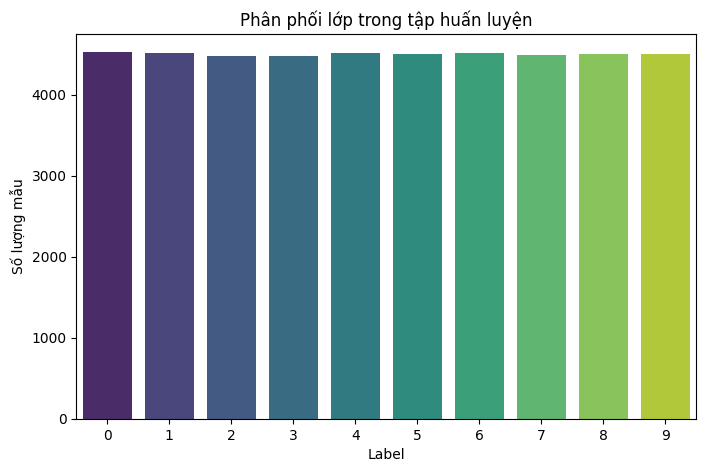

Độ lệch chuẩn số lượng mẫu mỗi lớp: 15.91
Độ lệch chuẩn / trung bình (%): 0.35%


In [ ]:
# Tính số lượng mẫu theo từng lớp trong dữ liệu huấn luyện
unique, counts = np.unique(y_train, return_counts=True)

# Vẽ biểu đồ phân phối
plt.figure(figsize=(8, 5))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.title("Phân phối lớp trong tập huấn luyện")
plt.xlabel("Label")
plt.ylabel("Số lượng mẫu")
plt.show()

# Tính độ lệch chuẩn giữa các lớp
std_dev = np.std(counts)
mean = np.mean(counts)
print(f"Độ lệch chuẩn số lượng mẫu mỗi lớp: {std_dev:.2f}")
print(f"Độ lệch chuẩn / trung bình (%): {(std_dev / mean * 100):.2f}%")


In [ ]:
# Đường dẫn tới thư mục chứa các file CIFAR-10
data_dir = '/content/sample_data'

# Hàm tải một batch dữ liệu CIFAR-10
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    images = dict[b'data']
    labels = dict[b'labels']
    images = images.reshape(len(images), 3, 32, 32).transpose(0, 2, 3, 1)
    images = images.astype('float32') / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

# Tải toàn bộ dữ liệu train
X, y = [], []
for i in range(1, 6):
    file_path = os.path.join(data_dir, f'data_batch_{i}')
    images, labels = load_cifar_batch(file_path)
    X.append(images)
    y.append(labels)

X = np.concatenate(X)
y = np.concatenate(y)
y_cat = to_categorical(y, num_classes=10)

# Tách tập validation
train_X, val_X, train_y, val_y = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Hàm xây dựng mô hình CNN cơ bản
def build_model():
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

# Cấu hình huấn luyện
configs = [
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam'},
    {'lr': 0.0005, 'batch_size': 128, 'optimizer': 'adam'},
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'sgd'}
]

results = []
best_val_acc = 0
best_model = None

# Huấn luyện với từng cấu hình
for config in configs:
    print(f"\n Huấn luyện với config: {config}")
    model = build_model()

    if config['optimizer'] == 'adam':
        opt = Adam(learning_rate=config['lr'])
    else:
        opt = SGD(learning_rate=config['lr'])

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_X, train_y,
        epochs=10,
        batch_size=config['batch_size'],
        validation_data=(val_X, val_y),
        verbose=2
    )

    val_loss, val_acc = model.evaluate(val_X, val_y, verbose=0)
    results.append({'config': config, 'val_acc': val_acc, 'val_loss': val_loss})

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_config = config

# Hiển thị kết quả từng cấu hình
print("\n📊 Kết quả các cấu hình:")
for res in results:
    cfg = res['config']
    print(f"Config={cfg} | Val Accuracy={res['val_acc']:.4f} | Val Loss={res['val_loss']:.4f}")

# Tải và xử lý test_batch
def load_test_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    images = dict[b'data']
    labels = dict[b'labels']
    images = images.reshape(len(images), 3, 32, 32).transpose(0, 2, 3, 1)
    images = images.astype('float32') / 255.0
    labels = np.array(labels)
    return images, labels

test_X, test_y = load_test_batch(os.path.join(data_dir, 'test_batch'))
test_y_cat = to_categorical(test_y, num_classes=10)

# Đánh giá mô hình tốt nhất trên test set
print(f"\n✅ Đánh giá mô hình tốt nhất với config: {best_config}")
test_loss, test_acc = best_model.evaluate(test_X, test_y_cat, verbose=2)
print(f"🎯 Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")



🔧 Huấn luyện với config: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam'}
Epoch 1/10
625/625 - 8s - 13ms/step - accuracy: 0.3505 - loss: 1.7614 - val_accuracy: 0.5088 - val_loss: 1.3991
Epoch 2/10
625/625 - 3s - 5ms/step - accuracy: 0.5022 - loss: 1.3791 - val_accuracy: 0.5677 - val_loss: 1.2012
Epoch 3/10
625/625 - 5s - 8ms/step - accuracy: 0.5722 - loss: 1.1950 - val_accuracy: 0.6465 - val_loss: 0.9985
Epoch 4/10
625/625 - 3s - 4ms/step - accuracy: 0.6195 - loss: 1.0824 - val_accuracy: 0.6672 - val_loss: 0.9341
Epoch 5/10
625/625 - 5s - 9ms/step - accuracy: 0.6518 - loss: 0.9889 - val_accuracy: 0.6921 - val_loss: 0.8646
Epoch 6/10
625/625 - 5s - 8ms/step - accuracy: 0.6798 - loss: 0.9133 - val_accuracy: 0.6785 - val_loss: 0.9072
Epoch 7/10
625/625 - 3s - 4ms/step - accuracy: 0.7015 - loss: 0.8490 - val_accuracy: 0.6965 - val_loss: 0.8467
Epoch 8/10
625/625 - 3s - 5ms/step - accuracy: 0.7219 - loss: 0.7938 - val_accuracy: 0.7210 - val_loss: 0.7986
Epoch 9/10
625/625 - 3s - 5ms/st